# USNM 2P data analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack, view_interactive_plot
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()

# Logger level
logger.setLevel(logging.INFO)

## General parameters

 17/11/2021 16:58:13: input data directory:
/Users/tlemaire/Documents/data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1
 17/11/2021 16:58:13: figures directory:
/Users/tlemaire/Documents/data/yiyuan/figs


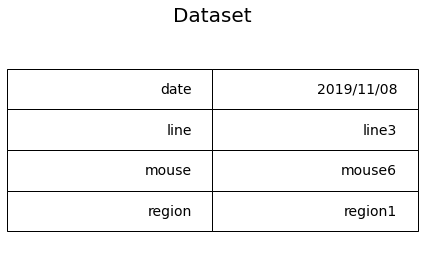

In [3]:
# Input data directory
dataroot = get_data_root() # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory:\n{datadir}')

# Figures dictionary
figsdir = os.path.join(split_path_at(dataroot, 'raw')[0], 'figs')
if not os.path.isdir(figsdir):
    os.makedirs(figsdir)
logger.info(f'figures directory:\n{figsdir}')
figs = {}

# Create table figure summarizing dataset info
figs['dataset_info'] = plot_table({
    'date': f'{date[4:]}/{date[:2]}/{date[2:4]}',
    'line': line,
    'mouse': mouse,
    'region': region
    })

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

 17/11/2021 16:58:13: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753']


### Merge TIFs into stack

In [5]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + STIM_FRAME_INDEX

 17/11/2021 16:58:13: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 17/11/2021 16:58:13: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 17/11/2021 16:58:14: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 17/11/2021 16:58:14: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 17/11/2021 16:58:14: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 17/11/2021 16:58:14: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize stack for a randomly chosen run

 17/11/2021 16:58:15: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 17/11/2021 16:58:16: initializing stack viewer
 17/11/2021 16:58:16: stack size: (1600, 256, 256)
 17/11/2021 16:58:16: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5529.71it/s]

 17/11/2021 16:58:17: intensity range: 32 - 1906


 17/11/2021 16:58:17: adding 16 delimiters


100%|██████████| 1600/1600 [00:00<00:00, 7828.75it/s]

 17/11/2021 16:58:17: initializing stack viewer
 17/11/2021 16:58:17: stack size: (1600, 256, 256)
 17/11/2021 16:58:17: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5856.92it/s]

 17/11/2021 16:58:17: intensity range: 32 - 1906
 17/11/2021 16:58:17: rendering stack view...


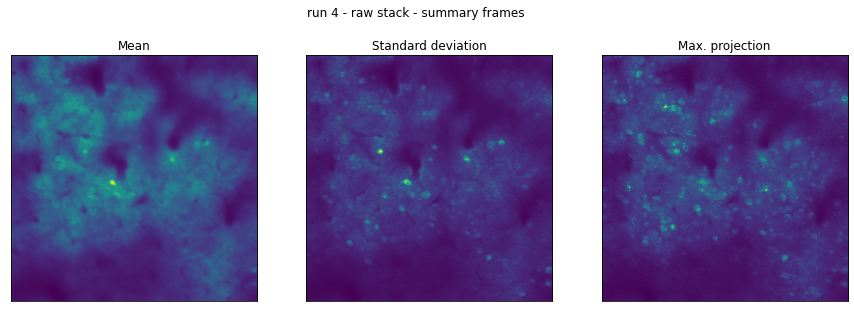

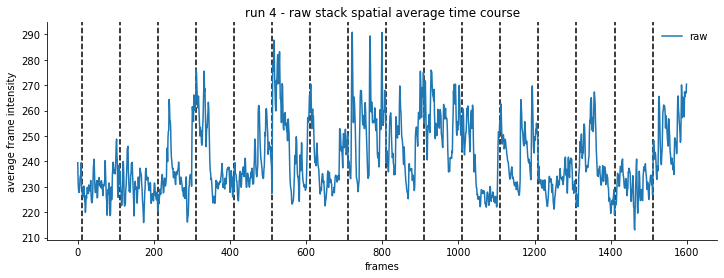

In [6]:
# Run index
irun = 4

from plotters import plot_mean_evolution

# Load stack
raw_stack = loadtif(raw_stack_fpaths[irun])

# Plot stack summary images
figs[f'raw_stack_run{irun}'] = plot_stack_summary(
    raw_stack, title=f'run {irun} - raw stack')

# Plot time course of the stack spatial average
figs[f'raw_stack_timecourse_run{irun}'] = plot_mean_evolution(
    {'raw': raw_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, title=f'run {irun} - raw stack')

# View stack 
view_stack({
    'raw': raw_stack_fpaths[irun]}, title=f'run {irun}', ilabels=i_stim_frames_run)

We notice a significant amount of Speckle noise in the acquired images, especially on the frames corresponding to stimulation episodes.

## Interpolation of stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we replace them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [7]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Interpolate every TIF stack and save outputs in specific directory 
input_root = 'stacked'
interpolated_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

 17/11/2021 16:58:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 17/11/2021 16:58:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 17/11/2021 16:58:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 17/11/2021 16:58:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 17/11/2021 16:58:17: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3

### View stack interpolation output for the same run

 17/11/2021 16:58:17: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 17/11/2021 16:58:18: initializing stack viewer
 17/11/2021 16:58:18: stack size: (1600, 256, 256)
 17/11/2021 16:58:18: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5823.81it/s]

 17/11/2021 16:58:19: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5855.27it/s]

 17/11/2021 16:58:19: intensity range: 32 - 1906
 17/11/2021 16:58:19: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 7833.87it/s]

 17/11/2021 16:58:19: initializing stack viewer
 17/11/2021 16:58:19: stack size: (1600, 256, 256)
 17/11/2021 16:58:19: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5808.55it/s]

 17/11/2021 16:58:20: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5776.98it/s]

 17/11/2021 16:58:20: intensity range: 32 - 1906
 17/11/2021 16:58:20: rendering stack view...


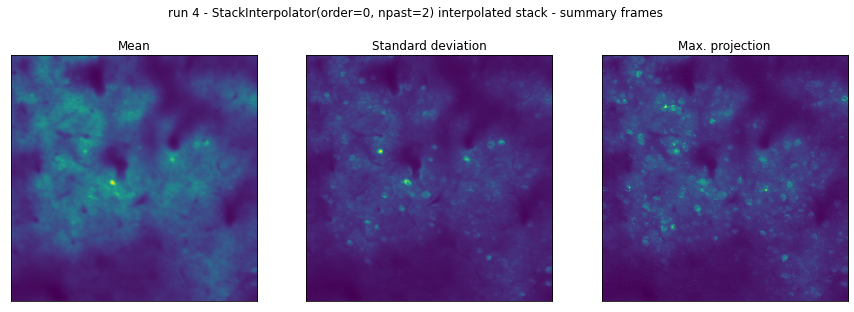

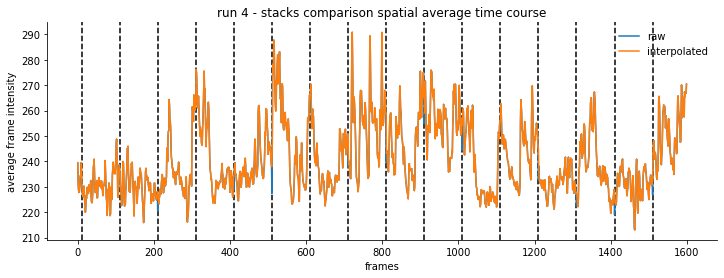

In [8]:
# Load interpolated stack for the same run
interpolated_stack = loadtif(interpolated_stack_fpaths[irun])

# Plot interpolated stack summary images
figs[f'interp_stack_run{irun}'] = plot_stack_summary(
    interpolated_stack, title=f'run {irun} - {si} interpolated stack')

# Plot comparative time course of the stacks spatial average
figs[f'interp_stack_timecourse_run{irun}'] = plot_mean_evolution({
    'raw': raw_stack_fpaths[irun],
    'interpolated': interpolated_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw and inteprolated stacks side-by-side
view_stack({
    'raw': raw_stack_fpaths[irun],
    si: interpolated_stack_fpaths[irun]},
    title=f'run {irun}', ilabels=i_stim_frames_run, norm=True)

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [9]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'interpolated'
filtered_stack_fpaths = process_and_save(kd, interpolated_stack_fpaths, input_root, overwrite=False)

 17/11/2021 16:58:20: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 17/11/2021 16:58:20: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 17/11/2021 16:58:20: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 17/11/2021 16:58:20: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 17/11/2021 16:58:20: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order

### View stack denoising output for a particular stack

 17/11/2021 16:58:20: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 17/11/2021 16:58:22: initializing stack viewer
 17/11/2021 16:58:22: stack size: (1600, 256, 256)
 17/11/2021 16:58:22: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5250.46it/s]

 17/11/2021 16:58:22: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5469.14it/s]

 17/11/2021 16:58:22: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5625.90it/s]

 17/11/2021 16:58:22: intensity range: 63 - 1414
 17/11/2021 16:58:22: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 7706.17it/s]

 17/11/2021 16:58:23: initializing stack viewer
 17/11/2021 16:58:23: stack size: (1600, 256, 256)
 17/11/2021 16:58:23: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5767.70it/s]

 17/11/2021 16:58:23: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5811.09it/s]

 17/11/2021 16:58:24: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5782.00it/s]

 17/11/2021 16:58:24: intensity range: 63 - 1414
 17/11/2021 16:58:24: rendering stack view...


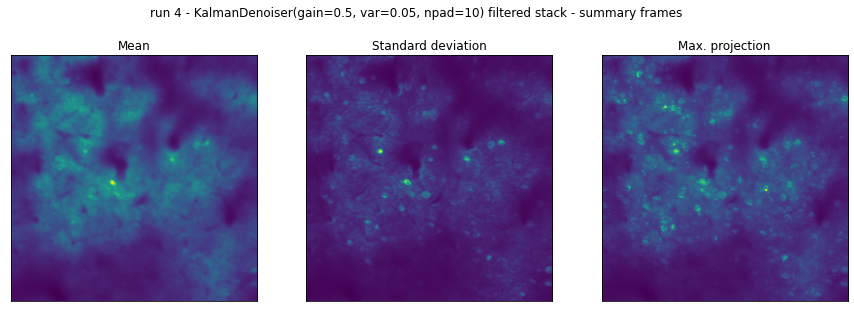

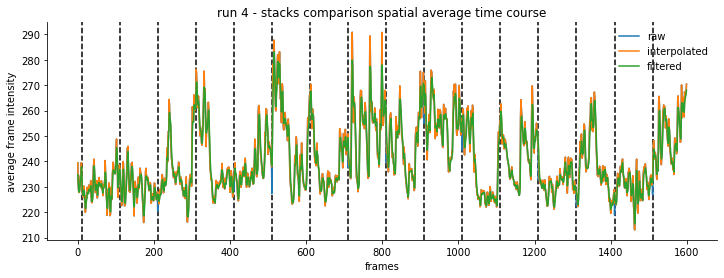

In [10]:
# Load denoised stack for the same run
filtered_stack = loadtif(filtered_stack_fpaths[irun])

# Plot denoised stack summary images
figs[f'filtered_stack_run{irun}'] = plot_stack_summary(
    filtered_stack, title=f'run {irun} - {kd} filtered stack')

# Plot comparative time course of the stacks spatial average
figs[f'filtered_stack_timecourse_run{irun}'] = plot_mean_evolution({
    'raw': raw_stack_fpaths[irun],
    'interpolated': interpolated_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw, inteprolated and denoised stacks side-by-side
view_stack({
    'raw': raw_stack_fpaths[irun],
    si: interpolated_stack_fpaths[irun],
    kd: filtered_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, norm=True)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [11]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, FPS_LABEL)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

 17/11/2021 16:58:24: parsed frame rate = 3.56 fps
 17/11/2021 16:58:24: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1


### Run suite2p with custom options

In [12]:
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

 17/11/2021 16:58:24: running suite2p 0.10.2 with the following options:
{'denoise': True, 'fs': 3.56, 'nonrigid': True, 'reg_tif': True, 'tau': 1.25}
 17/11/2021 16:58:24: data will be saved in suite2p base directory "suite2p_denoise_fs_3.56_reg_tif_tau_1.25"
 17/11/2021 16:58:24: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/suite2p_denoise_fs_3.56_reg_tif_tau_1.25/plane0"
 17/11/2021 16:58:24: run options match 100% -> ignoring
 17/11/2021 16:58:24: empty data path -> no run


### Load suite2p ouput data

In [13]:
# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
all_s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = all_s2p_data.pop('ops')

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info('output info table corresponding to suite2p processing order:')
output_info_table

 17/11/2021 16:58:24: extracted data contains 516 ROIs
 17/11/2021 16:58:25: output info table corresponding to suite2p processing order:


,line,trial_length,duration (s),fps,P (MPa),DC (%),run ID,ntrials
run,,,,,,,,
0,line3,100,0.2,3.56,0.00,50.0,757,16
1,line3,100,0.2,3.56,0.10,50.0,755,16
2,line3,100,0.2,3.56,0.20,50.0,754,16
3,line3,100,0.2,3.56,0.40,50.0,753,16
4,line3,100,0.2,3.56,0.05,50.0,756,16
5,line3,100,0.2,3.56,0.60,50.0,752,16
6,line3,100,0.2,3.56,0.80,5.0,748,16
7,line3,100,0.2,3.56,0.80,10.0,747,16
8,line3,100,0.2,3.56,0.80,20.0,746,16


### Plot suite2p summary images

 17/11/2021 16:58:25: plotting suite2p registered images...


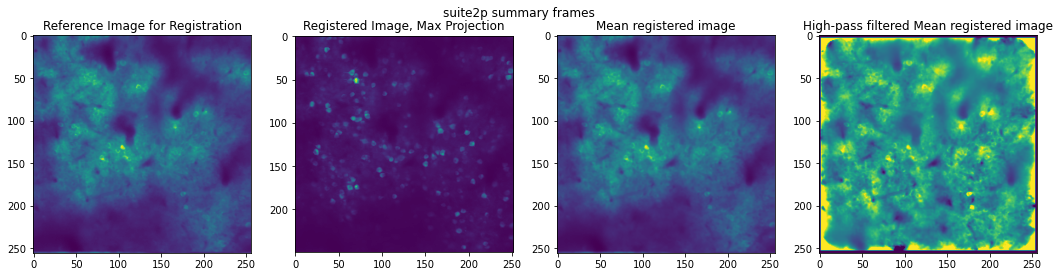

In [14]:
figs['registered_images'] = plot_suite2p_registration_images(s2p_ops, title='suite2p summary frames')

### Plot suite2p registration offsets

 17/11/2021 16:58:25: plotting suite2p registration offsets...


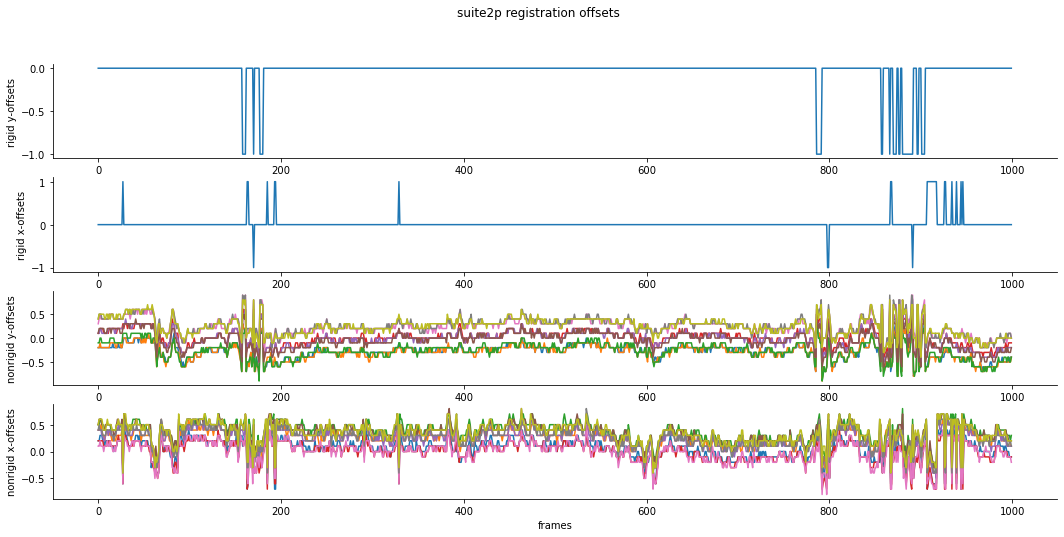

In [15]:
figs['registered_offsets'] = plot_suite2p_registration_offsets(s2p_ops, 'suite2p registration offsets')

### Visualize registered stack (for the same run as before)

In [16]:
istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
for i in range(nruns):
    istimframes_stacked[i] += i * nframes_per_run
istimframes_stacked = istimframes_stacked.flatten()
irun_eq = output_to_input_mapping[irun]
runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
view_stack(
    s2p_ops, title=f'registered stack (run {irun} -> output {irun_eq})',
    bounds=runbounds, ilabels=istimframes_stacked)

 17/11/2021 16:58:25: initializing stack viewer
 17/11/2021 16:58:25: stack size: (24000, 256, 256)
 17/11/2021 16:58:25: frame frange: [8000, 9599]
 17/11/2021 16:58:25: computing stack intensity range across 8000 - 9599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 4728.32it/s]

 17/11/2021 16:58:26: intensity range: 50 - 393
 17/11/2021 16:58:26: rendering stack view...


### Compare average frame intensity for specific run

That is a good opportunity to check that our mapping of input stacks to suite2p output stacks is correct.

 17/11/2021 16:58:26: initializing stack viewer
 17/11/2021 16:58:26: stack size: (1600, 256, 256)
 17/11/2021 16:58:26: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 4795.46it/s]

 17/11/2021 16:58:26: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5005.73it/s]

 17/11/2021 16:58:26: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 4939.89it/s]

 17/11/2021 16:58:27: intensity range: 63 - 1414
 17/11/2021 16:58:27: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 7651.12it/s]

 17/11/2021 16:58:27: initializing stack viewer
 17/11/2021 16:58:27: stack size: (24000, 256, 256)
 17/11/2021 16:58:27: frame frange: [8000, 9599]
 17/11/2021 16:58:27: computing stack intensity range across 8000 - 9599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 6172.29it/s]

 17/11/2021 16:58:28: intensity range: 50 - 393



100%|██████████| 1600/1600 [00:01<00:00, 1367.36it/s]


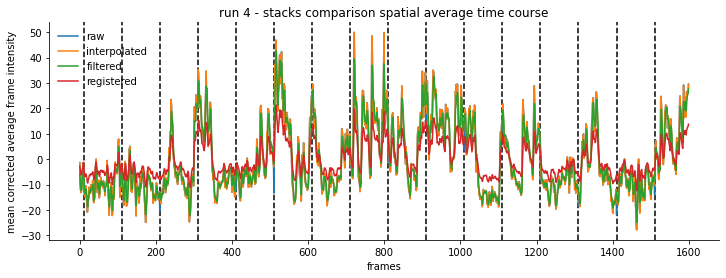

In [17]:
# Plot comparative time course of the stacks spatial average
fig = plot_mean_evolution({
    'raw': raw_stack_fpaths[irun],
    'interpolated': interpolated_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    }, 
    correct=True,
    ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')
figs[f'registered_stack_timecourse_run{irun}'] = plot_mean_evolution(
    s2p_ops, title='registered', bounds=runbounds, ax=fig.axes[0], correct=True)

### Inspect suite2p ROIs

 17/11/2021 16:58:29: plotting suite2p identified ROIs...


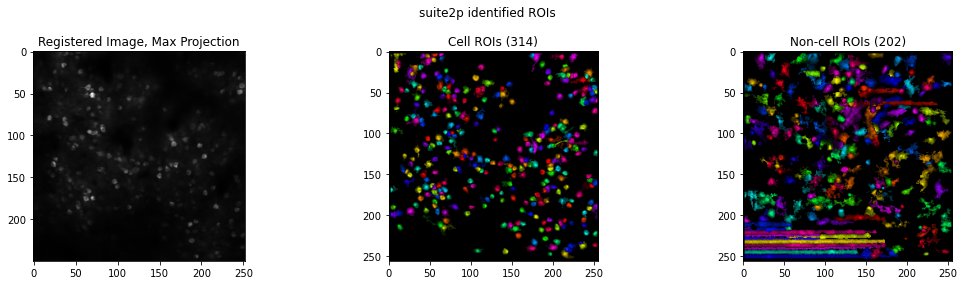

In [18]:
figs['identified_ROIs'] = plot_suite2p_ROIs(all_s2p_data, s2p_ops, title='suite2p identified ROIs')

### Get fluorescence timeseries data

In [19]:
all_Ftimeseries = arrays_to_dataframe({
    F_ROI_LABEL: all_s2p_data['F'],
    F_NEU_LABEL: all_s2p_data['Fneu']},
    dim_names=[ROI_LABEL, FRAME_LABEL])
logger.info(f'assembled {describe_dataframe_index(all_Ftimeseries)} fluorescence timeseries dataframe:')
all_Ftimeseries

 17/11/2021 16:58:31: assembled 516 ROIs x 24000 frames fluorescence timeseries dataframe:


F_ROI (a.u.)  F_neu (a.u.)
ROI frame                            
0   0        181.027191    143.495407
    1        192.738037    147.502747
    2        193.219131    147.717438
    3        189.408936    146.339447
    4        178.830154    143.121094
...                 ...           ...
515 23995    105.690468    106.046509
    23996    107.762451    106.790695
    23997    105.807793    105.348839
    23998    102.846825    105.206718
    23999    104.054207    106.857880

[12384000 rows x 2 columns]

## Post-processing

### Filter out non-cell ROIs

In [20]:
iscell = all_s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
cell_Ftimeseries = all_Ftimeseries.loc[(icells)]
cell_s2p_data = filter_s2p_data(all_s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(cell_Ftimeseries)} fluorescence timeseries dataframe')

 17/11/2021 16:58:32: filtered to 314 ROIs x 24000 frames fluorescence timeseries dataframe


### Discard outliers based on morphological properties

 17/11/2021 16:58:32: updating dataset...
 17/11/2021 16:58:32: filtered to 312 ROIs x 24000 frames fluorescence timeseries dataframe
 17/11/2021 16:58:32: identified 2 outlier(s):


,compact,solidity,npix,npix_soma,radius,aspect_ratio,skew,is_outlier
ROI,,,,,,,,
159,False,False,True,False,False,False,False,True
172,True,False,False,False,False,False,False,True


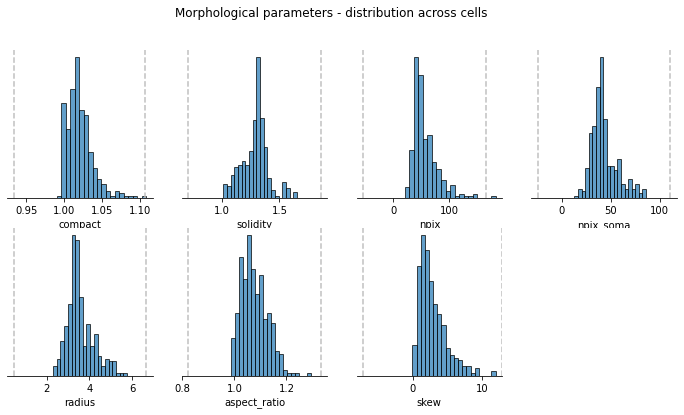

In [21]:
# Plot distributions and identify outliers
pkeys = [
    'compact',
    'solidity',
    'npix',
    'npix_soma',
    'radius',
    'aspect_ratio',
    'skew',
]
figs['morpho_params_cells'], df_outliers = plot_parameter_distributions(
    cell_s2p_data, pkeys, zthr=5)
df_outliers['is_outlier'] = df_outliers[pkeys].sum(axis=1).astype(bool)
df_outliers[ROI_LABEL] = icells
df_outliers = df_outliers.set_index(ROI_LABEL)
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = cell_Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(cell_s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### Select subset of ROIs and runs to plot

 17/11/2021 16:58:33: randomly selecting 1 ROI for plotting (index = 70)
 17/11/2021 16:58:33: sub-indexing data...
 17/11/2021 16:58:33: filtering data...
 17/11/2021 16:58:33: cross-checking filters...
 17/11/2021 16:58:33: plotting 2 fluorescence trace(s)...
 17/11/2021 16:58:33: adding 16 delimiters


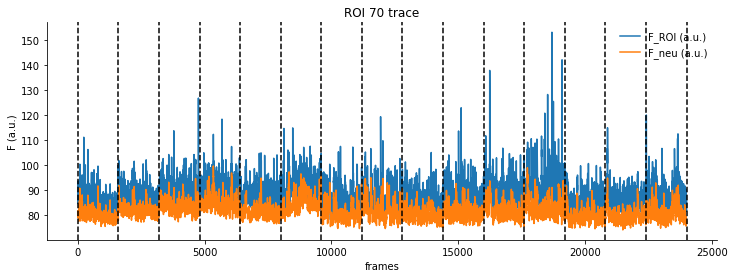

In [22]:
# Select subset of ROIs
iROIs = Ftimeseries.index.unique(level=ROI_LABEL)
iROI_plt = np.random.choice(iROIs, size=1)[0]
logger.info(f'randomly selecting 1 ROI for plotting (index = {iROI_plt})')

# Find run with high P and DC to plot
irun_plt = output_info_table[
    (output_info_table[P_LABEL] == P_REF) & (output_info_table[DC_LABEL] == DC_REF)
    ].index[0]

# Plot longitudinal fluorescence traces for selected ROI
run_delimiters = np.arange(nruns + 1) * nframes_per_run
figs['raw_F_traces'] = plot_traces(
    Ftimeseries[[F_ROI_LABEL, F_NEU_LABEL]], ylabel='F (a.u.)',
    iROI=iROI_plt, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

 17/11/2021 16:58:33: subtracting neuropil background with alpha = 0.7 ...
 17/11/2021 16:58:33: sub-indexing data...
 17/11/2021 16:58:33: filtering data...
 17/11/2021 16:58:33: cross-checking filters...
 17/11/2021 16:58:33: plotting 1 fluorescence trace(s)...
 17/11/2021 16:58:33: adding 16 delimiters


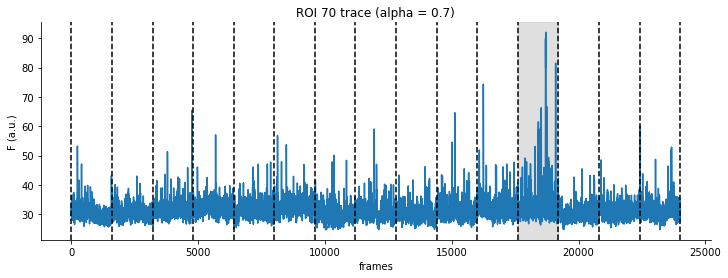

In [23]:
# Subtract neuropil background fluorescence each ROI of interest
from constants import ALPHA
logger.info(f'subtracting neuropil background with alpha = {ALPHA} ...')
Ftimeseries[F_LABEL] = Ftimeseries[F_ROI_LABEL] - ALPHA * Ftimeseries[F_NEU_LABEL]

# Plot longitudinal fluorescence traces for selected ROI
run_delimiters = np.arange(nruns + 1) * nframes_per_run
figs['F_trace'] = plot_traces(
    Ftimeseries[[F_LABEL]],
    iROI=iROI_plt, delimiters=run_delimiters,
    title=f'alpha = {ALPHA}')
# Highlight selected run on figure
figs['F_trace'].axes[0].axvspan(run_delimiters[irun_plt], run_delimiters[irun_plt + 1], color='silver', alpha=0.5);

### Split the data into separate runs

 17/11/2021 16:58:33: splitting fluorescence data into 15 separate runs...
 17/11/2021 16:58:34: sub-indexing data...
 17/11/2021 16:58:35: filtering data...
 17/11/2021 16:58:35: cross-checking filters...
 17/11/2021 16:58:35: plotting 1 fluorescence trace(s)...
 17/11/2021 16:58:35: adding 16 delimiters


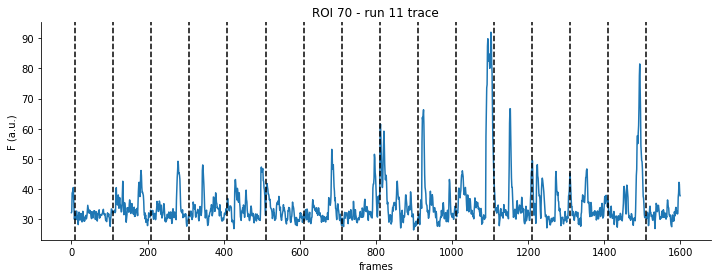

In [24]:
# Split the data into separate runs
Ftimeseries = separate_runs(Ftimeseries, nruns)
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + STIM_FRAME_INDEX

# Plot fluorescence timecourse of selected ROI for selected run
figs[f'F_trace_run{irun_plt}'] = plot_traces(
        Ftimeseries[[F_LABEL]],
        iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Compute time-varying fluorescence baseline

To do so, we apply a low percentile sliding window over the entire fluorescence timecourse.

This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

 17/11/2021 16:58:35: computing signal baseline as 5th percentile of 30.0s (107 frames) sliding window


4680it [00:07, 634.00it/s]                          

 17/11/2021 16:58:42: sub-indexing data...


 17/11/2021 16:58:43: filtering data...
 17/11/2021 16:58:43: cross-checking filters...
 17/11/2021 16:58:43: ambiguous y-labeling for more than 1 signal
 17/11/2021 16:58:43: plotting 2 fluorescence trace(s)...
 17/11/2021 16:58:43: adding 16 delimiters


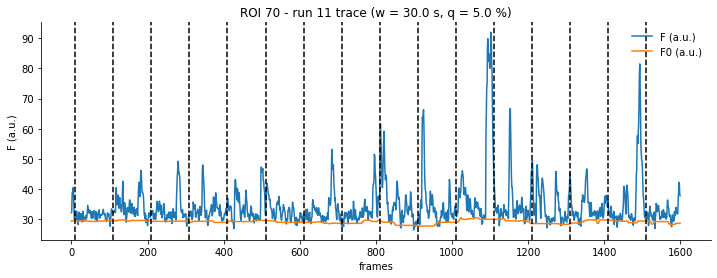

In [25]:
from constants import BASELINE_WLEN, BASELINE_QUANTILE
Ftimeseries[F0_LABEL] = compute_baseline(
    Ftimeseries[F_LABEL], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
figs[f'F_F0_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[F_LABEL, F0_LABEL]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters,
    title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

### Remove outliers with fluctuating baseline

For downstream analysis steps, we wish to consider only cells who exhibiit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

 17/11/2021 16:58:43: computing baseline relative standard deviation...
 17/11/2021 16:58:44: identifying outliers...
 17/11/2021 16:58:44: updating dataset...
 17/11/2021 16:58:44: filtered to 311 ROIs x 15 runs x 1600 frames fluorescence dataframe
 17/11/2021 16:58:44: identified 1 outlier(s):


,max F0 RSD,is_outlier
ROI,,
394,3.067435,True


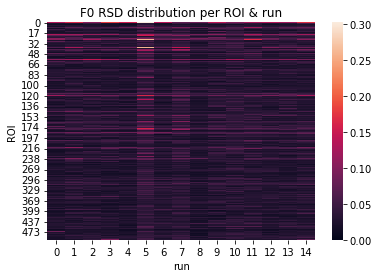

In [26]:
from constants import BASELINE_RSD_THR

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = Ftimeseries[F0_LABEL].groupby([ROI_LABEL, RUN_LABEL]).agg(
    lambda x: np.std(x) / np.abs(x.mean()))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(ROI_LABEL).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0)
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence dataframe')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### Split the fluorescence data into separate trials and remove first trials of each condition

<span style="color:red">NOTE: on the acquisition side, nothing is wrong with the first trial of each condition. However, since the different runs were fed together into suite2p (in order to improve ROI identification), the resulting fluorescence timecourses for each ROI were computed by suite2p under the assumption of time continuity, which is NOT the case during run-to-run transitions. We therefore discard the first trial of each run, since the fluorescence data is physiologically invalid around these transitions.</span>

In [27]:
# Split fluorescence data into separate trials
Ftimeseries = separate_trials(Ftimeseries, ntrials_per_run)

# Discard first trial of each run (if not done already)
i_first_trial = Ftimeseries.index.unique(level=TRIAL_LABEL)[0]
if i_first_trial == 0:
    logger.info('removing first trial of each run...')
    Ftimeseries = Ftimeseries.loc[:, :, 1:, :]
else:
    logger.warning('first trial already removed -> ignoring')

 17/11/2021 16:58:44: splitting fluorescence data into 16 separate trials...
 17/11/2021 16:58:46: removing first trial of each run...


### Compute relative fluorescence change

 17/11/2021 16:58:47: computing relative change in fluorescence...
 17/11/2021 16:58:59: sub-indexing data...
 17/11/2021 16:59:00: filtering data...
 17/11/2021 16:59:00: cross-checking filters...
 17/11/2021 16:59:00: plotting 1 fluorescence trace(s)...
 17/11/2021 16:59:00: adding 16 delimiters


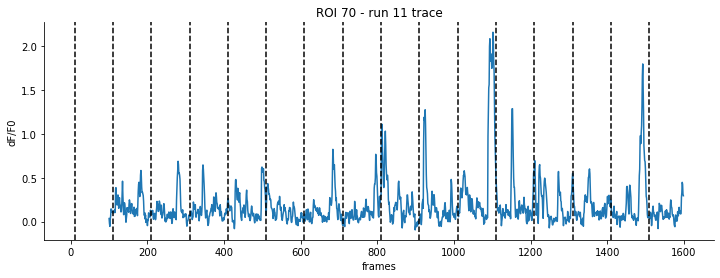

In [28]:
# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = Ftimeseries[F0_LABEL].groupby([ROI_LABEL, RUN_LABEL]).median()  # median of the baseline over each run
Ftimeseries[DFF_LABEL] = (Ftimeseries[F_LABEL] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
figs[f'dFF_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[DFF_LABEL]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Create statistics dataframe

In [29]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: Ftimeseries.index.unique(k) for k in Ftimeseries.index.names}

# Create Fstats dataframes
logger.info('creating statistics dataframe')
Fstats = pd.DataFrame()

 17/11/2021 16:59:00: creating statistics dataframe


### Compute dFF noise amplitude

 17/11/2021 16:59:00: computing signal baseline as 50th percentile of 60.0s (215 frames) sliding window


4665it [00:06, 671.06it/s]                          

 17/11/2021 16:59:07: computing dFF noise amplitude from event free periods...


 17/11/2021 16:59:08: plotting dFF noise per ROI & run...


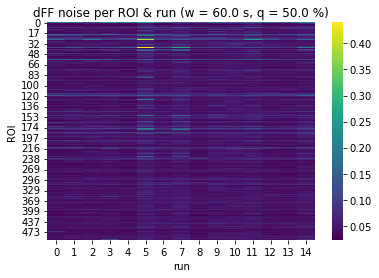

In [30]:
# Compute dFF noise threshold with a large sliding window
from constants import DFF_NOISE_WLEN, DFF_NOISE_QUANTILE
dFF_noise_thr = compute_baseline(
    Ftimeseries[DFF_LABEL], fps, DFF_NOISE_WLEN, DFF_NOISE_QUANTILE)

# Estimate dFF noise amplitude for each run from variation range below the median
logger.info('computing dFF noise amplitude from event free periods...')
dFF_noise = Ftimeseries[DFF_LABEL].copy()
dFF_noise[dFF_noise > dFF_noise_thr] = np.nan
dFF_noise_amp = dFF_noise.groupby([ROI_LABEL, RUN_LABEL]).std()

# Repeat along trials -> Fstats table
Fstats[DFF_NOISE_LABEL] = repeat_along_new_dim(
    dFF_noise_amp.to_frame(),
    TRIAL_LABEL, index_dims[TRIAL_LABEL])

# Plot average dFF noise amplitude distribution per ROI & run
figs['dFF_noise_map'] = plot_stat_heatmap(
    Fstats, DFF_NOISE_LABEL, cmap='viridis',
    title=f'w = {DFF_NOISE_WLEN:.1f} s, q = {DFF_NOISE_QUANTILE * 1e2:.1f} %')

### Compute z-score associated with relative fluorescence change

 17/11/2021 16:59:08: extracting dFF pre-stim level for each trial...
 17/11/2021 16:59:08: computing z-scores associated with relative change in fluorescence...
 17/11/2021 16:59:19: sub-indexing data...
 17/11/2021 16:59:19: filtering data...
 17/11/2021 16:59:19: cross-checking filters...
 17/11/2021 16:59:19: plotting 1 fluorescence trace(s)...
 17/11/2021 16:59:19: adding 16 delimiters


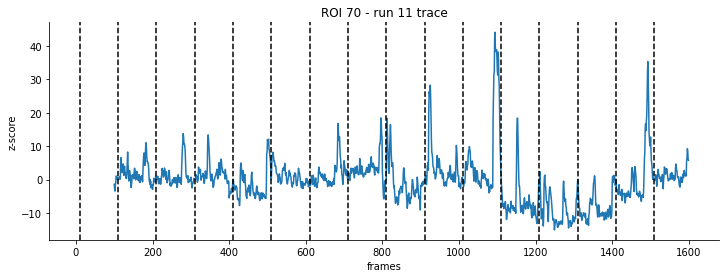

In [31]:
# Extract pre-stimulus dFF level
logger.info('extracting dFF pre-stim level for each trial...')
dFF_onset = Ftimeseries.loc[
    pd.IndexSlice[:, :, :, STIM_FRAME_INDEX], DFF_LABEL].droplevel(-1)
# Subtract stim dFF value and divide by dFF noise level to get z-score
logger.info('computing z-scores associated with relative change in fluorescence...')
Ftimeseries[ZSCORE_LABEL] = (Ftimeseries.loc[:, DFF_LABEL] - dFF_onset) / dFF_noise_amp

# Plot consecutive trials of z-score of selected ROI for selected run
figs[f'zscore_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[ZSCORE_LABEL]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Compute stimlulus-evoked peak z-score

 17/11/2021 16:59:20: identifying peak z-score in response window...
 17/11/2021 16:59:23: identified 69357 response peaks over 69975 trials (success rate = 99.1 %)
 17/11/2021 16:59:23: plotting trial-averaged peak z-score per ROI & run...


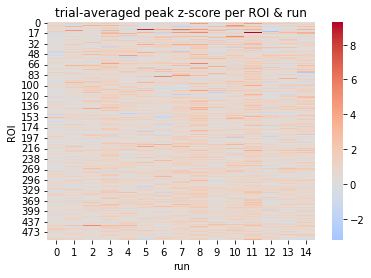

In [32]:
# Identify peak z-score in analysis window
logger.info('identifying peak z-score in response window...')
zscore_window = Ftimeseries.loc[pd.IndexSlice[:, :, :, I_RESPONSE], ZSCORE_LABEL]
Fstats[PEAK_ZSCORE_LABEL] = zscore_window.groupby(
    [ROI_LABEL, RUN_LABEL, TRIAL_LABEL]).agg(find_response_peak)
npeaks, ntrials = Fstats[PEAK_ZSCORE_LABEL].notna().sum(), len(Fstats)
logger.info(f'identified {npeaks} response peaks over {ntrials} trials (success rate = {npeaks / ntrials * 1e2:.1f} %)')

# Plot average peak z-score per ROI & run
figs['peak_zscore_map'] = plot_stat_heatmap(
    Fstats, PEAK_ZSCORE_LABEL, cmap='coolwarm')

### Compute response success rate

 17/11/2021 16:59:23: computing response success rate...
 17/11/2021 16:59:23: plotting success rate per ROI & run...


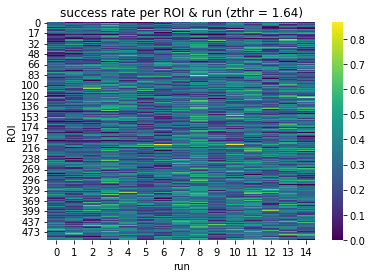

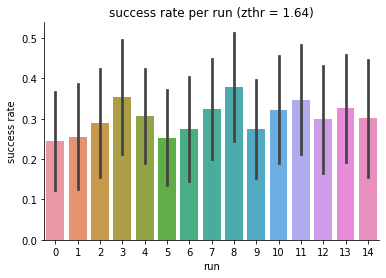

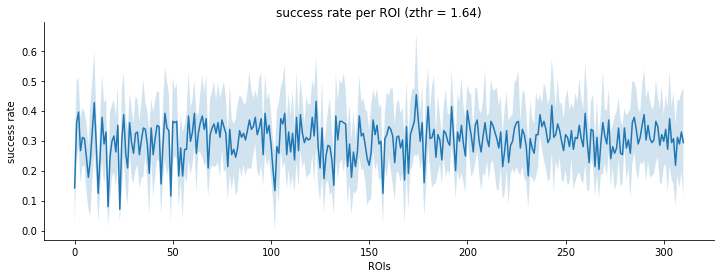

In [33]:
logger.info('computing response success rate...')
# Identify "proper" responses as those with a z-score above defined threshold 
Fstats[IS_RESP_LABEL] = Fstats[PEAK_ZSCORE_LABEL] > ZSCORE_THR
# Compute success rate per ROI and condition
success_rate = Fstats[IS_RESP_LABEL].groupby([ROI_LABEL, RUN_LABEL]).mean()

# Repeat success rate for every trial of the same run
Fstats[SUCCESS_RATE_LABEL] = repeat_along_new_dim(
    success_rate.to_frame(), 
    TRIAL_LABEL, index_dims[TRIAL_LABEL])

# Plot success rate per ROI & run
figs['sr_map'] = plot_stat_heatmap(
    Fstats, SUCCESS_RATE_LABEL, cmap='viridis',
    title=f'zthr = {ZSCORE_THR:.2f}')
# Plot success rate per run
figs['sr_per_run'] = plot_stat_per_run(
    Fstats, SUCCESS_RATE_LABEL,
    title=f'zthr = {ZSCORE_THR:.2f}')
# Plot success rate per ROI
figs['sr_per_ROI'] = plot_stat_per_ROI(
    Fstats, SUCCESS_RATE_LABEL,
    title=f'zthr = {ZSCORE_THR:.2f}')

### Compute corrected (response-only) z-scores

 17/11/2021 16:59:23: computing corrected z-scores (discarding no-response trials)...
 17/11/2021 16:59:35: plotting trial-averaged corrected peak z-score per ROI & run...


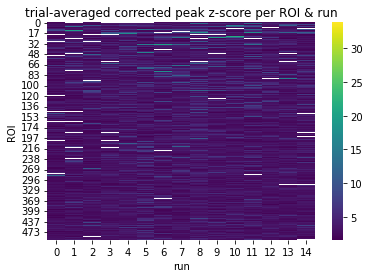

In [34]:
logger.info('computing corrected z-scores (discarding no-response trials)...')
# Extract z-scores from timeseries and stats tables
Ftimeseries[CORRECTED_ZSCORE_LABEL] = Ftimeseries[ZSCORE_LABEL]
Fstats[CORRECTED_PEAK_ZSCORE_LABEL] = Fstats[PEAK_ZSCORE_LABEL]
# Set no-response trials to NaN
noresp = ~Fstats[IS_RESP_LABEL]
Ftimeseries.loc[noresp, CORRECTED_ZSCORE_LABEL] = np.nan
Fstats.loc[noresp, CORRECTED_PEAK_ZSCORE_LABEL] = np.nan

# Plot corrected z-score per ROI & run
figs['corrected_peak_zscore_map'] = plot_stat_heatmap(
    Fstats, CORRECTED_PEAK_ZSCORE_LABEL, cmap='viridis')

### Classify response type per ROI

 17/11/2021 16:59:36: identifying "positive" runs for each ROI...
 17/11/2021 16:59:36: computing number of "positive" runs for each ROI...
 17/11/2021 16:59:36: classifying ROI response types...


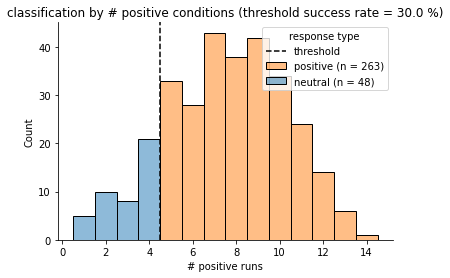

In [35]:
# Identify as "positive" runs those who are above a given success rate (for each ROI)
logger.info('identifying "positive" runs for each ROI...')
is_positive_run = get_trial_averaged(Fstats[SUCCESS_RATE_LABEL]) > SUCCESS_RATE_THR
# Repeat along trial dimension in Fstats table
Fstats[IS_POSITIVE_RUN_LABEL] = repeat_along_new_dim(
    is_positive_run.to_frame(), 
    TRIAL_LABEL, index_dims[TRIAL_LABEL])

# Compute number of "positive" runs for each ROI
logger.info('computing number of "positive" runs for each ROI...')
n_positive_runs = is_positive_run.groupby(ROI_LABEL).sum().rename(NPOS_RUNS_LABEL)
# Repeat along run & trial dimensions in Fstats table
Fstats[NPOS_RUNS_LABEL] = repeat_along_new_dims(
    n_positive_runs.to_frame(), 
    {k: index_dims[k] for k in [RUN_LABEL, TRIAL_LABEL]})

# Assign response type to each ROI based on number of positive conditions
logger.info('classifying ROI response types...')
resp_types = (n_positive_runs >= NPOS_CONDS_THR).astype(int).rename(ROI_RESP_TYPE_LABEL)
resp_types = resp_types.map(LABEL_BY_TYPE)

# Repeat along run & trial dimensions in Fstats table
Fstats[ROI_RESP_TYPE_LABEL] = repeat_along_new_dims(
    resp_types.to_frame(), 
    {k: index_dims[k] for k in [RUN_LABEL, TRIAL_LABEL]})

# Plot the histogram of the number of positive conditions per response type
nruns = len(is_positive_run.index.unique(level=RUN_LABEL))
figs[NPOS_RUNS_LABEL] = plot_positive_runs_hist(
    n_positive_runs, resp_types, nruns,
    title=f'threshold success rate = {SUCCESS_RATE_THR * 1e2} %')

### Print Fstats table

In [36]:
logger.info('Fstats table:')
Fstats

 17/11/2021 16:59:36: Fstats table:


dFF noise  peak z-score  trial response?  success rate  \
ROI run trial                                                           
0   0   1       0.160506      1.629249            False      0.266667   
        2       0.160506      1.855351             True      0.266667   
        3       0.160506     -0.007096            False      0.266667   
        4       0.160506      2.085610             True      0.266667   
        5       0.160506      1.776364             True      0.266667   
...                  ...           ...              ...           ...   
514 14  11      0.077762     -0.296612            False      0.000000   
        12      0.077762     -3.968488            False      0.000000   
        13      0.077762     -2.765765            False      0.000000   
        14      0.077762     -0.973187            False      0.000000   
        15      0.077762     -1.607085            False      0.000000   

               corrected peak z-score  positive run?  # positive runs  \
ROI run trial                                                           
0   0   1                         NaN          False                1   
        2                    1.855351          False                1   
        3                         NaN          False                1   
        4                    2.085610          False                1   
        5                    1.776364          False                1   
...                               ...            ...              ...   
514 14  11                        NaN          False                8   
        12                        NaN          False                8   
        13                        NaN          False                8   
        14                        NaN          False                8   
        15                        NaN          False                8   

              response type  
ROI run trial                
0   0   1           neutral  
        2           neutral  
        3           neutral  
        4           neutral  
        5           neutral  
...                     ...  
514 14  11         positive  
        12         positive  
        13         positive  
        14         positive  
        15         positive  

[69975 rows x 8 columns]

### Add everything to global data table

<span style="color:yellow">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [37]:
# Expand output table
logger.info('expanding output table along ROI, trial and frame dimensions...')
exp_output_table = output_info_table.copy()
for k in [NPERTRIAL_LABEL, NTRIALS_LABEL]:
    del exp_output_table[k]
exp_output_table = repeat_along_new_dims(
    exp_output_table,
    {k: index_dims[k] for k in [ROI_LABEL, TRIAL_LABEL, FRAME_LABEL]})
exp_output_table = exp_output_table.reorder_levels(list(index_dims.keys())).sort_index()
# Expand Fstats
logger.info('expanding Fstats along frame dimension...')
exp_Fstats = repeat_along_new_dim(Fstats, FRAME_LABEL, index_dims[FRAME_LABEL])
# Merge datasets
logger.info('merging datasets...')
data = pd.concat([exp_output_table, Ftimeseries, exp_Fstats], axis=1)
# Add time to dataset
data = add_time_to_table(data)
logger.info('data table:')
data

 17/11/2021 16:59:36: expanding output table along ROI, trial and frame dimensions...
 17/11/2021 16:59:42: expanding Fstats along frame dimension...
 17/11/2021 16:59:46: merging datasets...
 17/11/2021 16:59:49: adding time info to table...
 17/11/2021 16:59:52: data table:


time (s)   line  duration (s)  P (MPa)  DC (%)  run ID  \
ROI run trial frame                                                            
0   0   1     0      -2.808989  line3           0.2      0.0    50.0     757   
              1      -2.528090  line3           0.2      0.0    50.0     757   
              2      -2.247191  line3           0.2      0.0    50.0     757   
              3      -1.966292  line3           0.2      0.0    50.0     757   
              4      -1.685393  line3           0.2      0.0    50.0     757   
...                        ...    ...           ...      ...     ...     ...   
514 14  15    95     23.876404  line3           0.2      0.8    80.0     751   
              96     24.157303  line3           0.2      0.8    80.0     751   
              97     24.438202  line3           0.2      0.8    80.0     751   
              98     24.719101  line3           0.2      0.8    80.0     751   
              99     25.000000  line3           0.2      0.8    80.0     751   

                     F_ROI (a.u.)  F_neu (a.u.)   F (a.u.)  F0 (a.u.)  ...  \
ROI run trial frame                                                    ...   
0   0   1     0        168.144409    141.361465  69.191383  65.216416  ...   
              1        167.760254    142.605499  67.936409  65.216416  ...   
              2        171.451141    144.427521  70.351875  65.216416  ...   
              3        174.240143    144.644043  72.989311  65.216416  ...   
              4        170.864746    143.722931  70.258698  65.216416  ...   
...                           ...           ...        ...        ...  ...   
514 14  15    95       109.462318    103.979263  36.676834  32.345773  ...   
              96       111.942482    105.311058  38.224739  32.345773  ...   
              97       110.117363    105.131340  36.525429  32.345773  ...   
              98       108.078758    104.225807  35.120697  32.345773  ...   
              99       109.094688    105.140556  35.496300  32.345773  ...   

                      z-score  corrected z-score  dFF noise  peak z-score  \
ROI run trial frame                                                         
0   0   1     0     -0.508012                NaN   0.160506      1.629249   
              1     -0.623128                NaN   0.160506      1.629249   
              2     -0.401562                NaN   0.160506      1.629249   
              3     -0.159634                NaN   0.160506      1.629249   
              4     -0.410109                NaN   0.160506      1.629249   
...                       ...                ...        ...           ...   
514 14  15    95     0.236360                NaN   0.077762     -1.607085   
              96     0.767298                NaN   0.077762     -1.607085   
              97     0.184427                NaN   0.077762     -1.607085   
              98    -0.297402                NaN   0.077762     -1.607085   
              99    -0.168569                NaN   0.077762     -1.607085   

                     trial response?  success rate  corrected peak z-score  \
ROI run trial frame                                                          
0   0   1     0                False      0.266667                     NaN   
              1                False      0.266667                     NaN   
              2                False      0.266667                     NaN   
              3                False      0.266667                     NaN   
              4                False      0.266667                     NaN   
...                              ...           ...                     ...   
514 14  15    95               False      0.000000                     NaN   
              96               False      0.000000                     NaN   
              97               False      0.000000                     NaN   
              98               False      0.000000                     NaN   
              99            

## Experiments summary results 

### Spatial distribution of cells per response type

 17/11/2021 16:59:57: extracting responses types per ROI...
 17/11/2021 16:59:58: plotting cells map color-coded by response type...


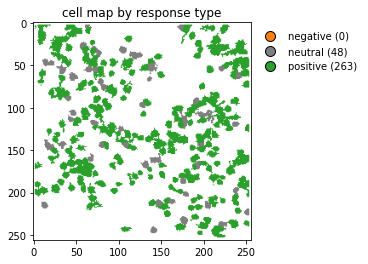

In [38]:
figs['cellmap'] = plot_cell_map(
    data, s2p_data, s2p_ops, title='cell map by response type')

## Response traces

### Plot parameters


In [39]:
tbounds_response = [-2, 8.]
ybounds_response = [-.2, .5]
ykey = ZSCORE_LABEL

### All traces for single ROI and condition

In [40]:
iROIs_interactive = data.index.unique(level=ROI_LABEL)
view_interactive_plot(
    lambda i: plot_responses(
        data, iROI=iROIs_interactive[i], irun=irun_plt,
        alltraces=True, label=SUCCESS_RATE_LABEL, ykey=ykey,
        mark_peaks=True, ci=None,
        tbounds=tbounds_response),
    len(iROIs_interactive));

### Visualize (ROI, run) combinations with best success rate

 17/11/2021 17:00:01: sub-indexing data...
 17/11/2021 17:00:01: filtering data...
 17/11/2021 17:00:01: cross-checking filters...
 17/11/2021 17:00:01: averaging and plotting mean z-score vs. time (s) ...
 17/11/2021 17:00:02: plotting individual z-score vs. time (s) traces...


1it [00:00, 33.46it/s]


 17/11/2021 17:00:02: sub-indexing data...
 17/11/2021 17:00:02: filtering data...
 17/11/2021 17:00:02: cross-checking filters...
 17/11/2021 17:00:02: averaging and plotting mean z-score vs. time (s) ...
 17/11/2021 17:00:02: plotting individual z-score vs. time (s) traces...


1it [00:00, 27.91it/s]


 17/11/2021 17:00:03: sub-indexing data...
 17/11/2021 17:00:03: filtering data...
 17/11/2021 17:00:03: cross-checking filters...
 17/11/2021 17:00:03: averaging and plotting mean z-score vs. time (s) ...
 17/11/2021 17:00:03: plotting individual z-score vs. time (s) traces...


1it [00:00, 34.70it/s]


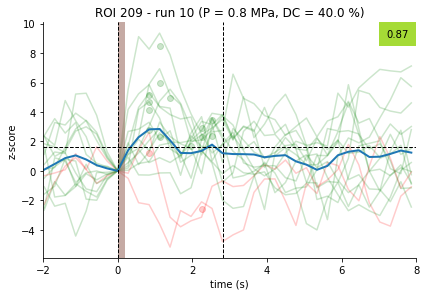

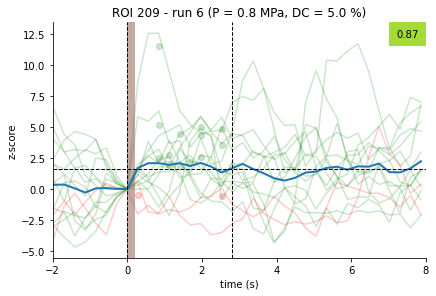

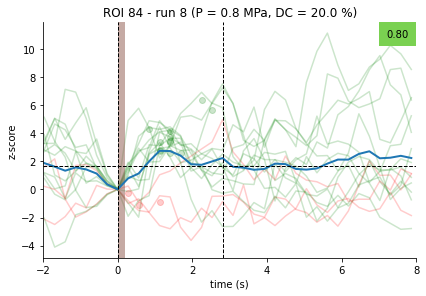

In [41]:
# Group by ROI and run, take first, sort by success rate, and select n bests 
ibests = data.groupby([ROI_LABEL, RUN_LABEL]).first().sort_values(
    SUCCESS_RATE_LABEL, ascending=False).head(3).index.values
for iROI, irun in ibests:
    figs[f'{ykey}_response_ROI{iROI}_run{irun}'] = plot_responses(
        data, iROI=iROI, irun=irun,
        alltraces=True, label=SUCCESS_RATE_LABEL, ykey=ykey,
        mark_peaks=True, ci=None,
        tbounds=tbounds_response)

### All ROIs for a given run

In [42]:
# fig = plot_responses(
#     data, col=ROI_LABEL, irun=irun_plt,
#     alltraces=True, ci=None, label=SUCCESS_RATE_LABEL, ykey=ZSCORE_LABEL,
#     # mark_peaks=True,
#     tbounds=tbounds_response)

### Parameter dependency for particular ROI 

In [43]:
# Pressure dependency
# figs[f'response_ROI{iROI}_DC{DC_REF}%'] = plot_responses(
#     data, iROI=iROI_plt, DC=DC_REF, ykey=ZSCORE_LABEL,
#     hue=P_LABEL, label=ROI_RESP_TYPE_LABEL,
#     tbounds=tbounds_response)
view_interactive_plot(
    lambda i: plot_responses(
        data, iROI=iROIs_interactive[i], DC=DC_REF, ykey=ZSCORE_LABEL,
        hue=P_LABEL, label=ROI_RESP_TYPE_LABEL,
        tbounds=tbounds_response),
    len(iROIs_interactive));

 17/11/2021 17:00:08: sub-indexing data...
 17/11/2021 17:00:08: filtering data...
 17/11/2021 17:00:08: cross-checking filters...
 17/11/2021 17:00:08: grouping by P (MPa), averaging, estimating confidence intervals and plotting mean z-score vs. time (s) ...
 17/11/2021 17:00:12: sub-indexing data...
 17/11/2021 17:00:12: filtering data...
 17/11/2021 17:00:12: cross-checking filters...
 17/11/2021 17:00:12: grouping by DC (%), averaging, estimating confidence intervals and plotting mean z-score vs. time (s) ...


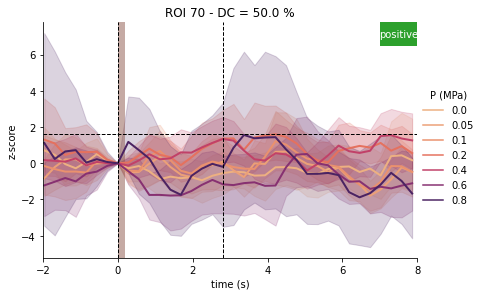

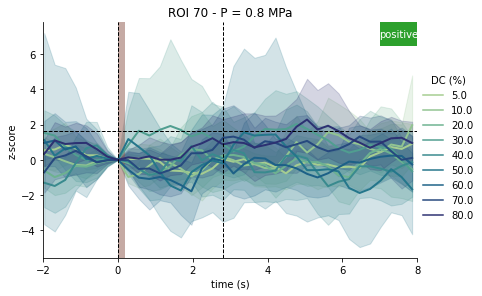

In [44]:
# Pressure dependency
figs[f'response_ROI{iROI}_DC{DC_REF}%'] = plot_responses(
    data, iROI=iROI_plt, DC=DC_REF, ykey=ZSCORE_LABEL,
    hue=P_LABEL, label=ROI_RESP_TYPE_LABEL,
    tbounds=tbounds_response)

# Duty-cycle dependency
figs[f'response_ROI{iROI}_P{P_REF}MPa_ci'] = plot_responses(
    data, iROI=iROI_plt, P=P_REF, ykey=ZSCORE_LABEL,
    hue=DC_LABEL, label=ROI_RESP_TYPE_LABEL,
    tbounds=tbounds_response)

### Response type dependency

In [45]:
# # Across conditions
# figs[f'responses_by_type'] = plot_responses(
#     data,
#     hue=ROI_RESP_TYPE_LABEL,
#     tbounds=tbounds_response)

# # Pressure dependency
# figs[f'responses_by_type_DC{DC_REF}%'] = plot_responses(
#     data, DC=DC_REF,
#     hue=P_LABEL, col=ROI_RESP_TYPE_LABEL,
#     tbounds=tbounds_response)

# # Duty cycle dependency
# figs[f'responses_by_type_P{P_REF}MPa'] = plot_responses(
#     data, P=P_REF,
#     hue=DC_LABEL, col=ROI_RESP_TYPE_LABEL,
#     tbounds=tbounds_response)

## Parameter dependency of response metrics

### Extract trial-averaged data

In [58]:
trialavg_data = get_trial_averaged(data)
logger.info('trial-averaged data:')
trialavg_data

 17/11/2021 17:33:57: trial-averaged data:


line  duration (s)  P (MPa)  DC (%)  run ID  F_ROI (a.u.)  \
ROI run                                                               
0   0    line3           0.2     0.00    50.0   757.0    185.101746   
    1    line3           0.2     0.10    50.0   755.0    203.756058   
    2    line3           0.2     0.20    50.0   754.0    232.675110   
    3    line3           0.2     0.40    50.0   753.0    238.265167   
    4    line3           0.2     0.05    50.0   756.0    196.516922   
...        ...           ...      ...     ...     ...           ...   
514 10   line3           0.2     0.80    40.0   744.0    121.513420   
    11   line3           0.2     0.80    50.0   743.0    127.171844   
    12   line3           0.2     0.80    60.0   749.0    119.025551   
    13   line3           0.2     0.80    70.0   750.0    119.423080   
    14   line3           0.2     0.80    80.0   751.0    118.415833   

         F_neu (a.u.)    F (a.u.)  F0 (a.u.)     dF/F0   z-score  \
ROI run                                                            
0   0      140.649414   86.647148  67.467363  0.275698  0.376102   
    1      149.751892   98.929749  79.670740  0.190202 -0.225203   
    2      154.668472  124.407166  96.884308  0.278429  0.285456   
    3      159.916412  126.323685  88.349387  0.401214 -0.077460   
    4      145.724701   94.509628  75.390028  0.308070 -0.157227   
...               ...         ...        ...       ...       ...   
514 10     112.747917   42.589890  38.465828  0.103262  0.702957   
    11     117.849785   44.676998  39.504983  0.130770  0.539651   
    12     107.875366   43.512798  39.805985  0.096117 -0.034891   
    13     108.360458   43.570759  39.794289  0.095711 -0.594413   
    14     108.740082   42.297783  37.404470  0.128200 -0.316036   

         corrected z-score  dFF noise  peak z-score  trial response?  \
ROI run                                                                
0   0             1.243435   0.160506      0.543765         0.266667   
    1                  NaN   0.176275     -0.269299         0.000000   
    2             1.644296   0.111484      0.162175         0.066667   
    3                  NaN   0.225705     -0.052621         0.000000   
    4                  NaN   0.183747     -0.279030         0.000000   
...                    ...        ...           ...              ...   
514 10            2.211925   0.038295      0.579392         0.400000   
    11            2.147678   0.048498      3.455707         0.600000   
    12            0.728490   0.037467      0.691074         0.466667   
    13            2.437183   0.035396     -0.217591         0.200000   
    14                 NaN   0.077762     -1.029385         0.000000   

         success rate  corrected peak z-score  positive run?  # positive runs  \
ROI run                                                                         
0   0        0.266667                1.897527            0.0              1.0   
    1        0.000000                     NaN            0.0              1.0   
    2        0.066667                2.792009            0.0              1.0   
    3        0.000000                     NaN            0.0              1.0   
    4        0.000000                     NaN            0.0              1.0   
...               ...                     ...            ...              ...   
514 10       0.400000                2.482835            1.0              8.0   
    11       0.600000                5.990509            1.0              8.0   
    12       0.466667                2.753012            1.0              8.0   
    13       0.200000                1.972118            0.0              8.0   
    14       0.000000                     NaN            0.0              8.0   

        response type  
ROI run                
0   0         neutral  
    1         neutral  
    2         neutral  
    3         neutral  
    4         neutral  
...               ...  
514 10       posit

### Success rate

 17/11/2021 17:34:17: sub-indexing data...
 17/11/2021 17:34:17: filtering data...
 17/11/2021 17:34:17: cross-checking filters...
 17/11/2021 17:34:17: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 17/11/2021 17:34:17: sub-indexing data...
 17/11/2021 17:34:17: filtering data...
 17/11/2021 17:34:17: cross-checking filters...
 17/11/2021 17:34:17: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. DC (%) ...


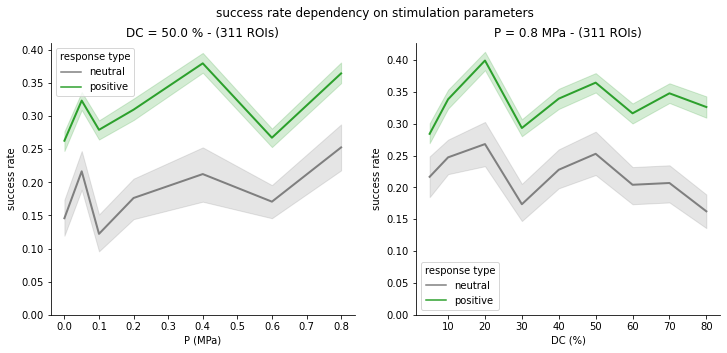

In [61]:
ykey = SUCCESS_RATE_LABEL
figs['success_rate_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([P_LABEL, DC_LABEL], axes):
    fig = plot_parameter_dependency(
        trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=ROI_RESP_TYPE_LABEL,
        ax=ax)
fig.suptitle('success rate dependency on stimulation parameters');

### Peak dFF z-score (raw and weighted by success rate)

 17/11/2021 17:34:18: sub-indexing data...
 17/11/2021 17:34:18: filtering data...
 17/11/2021 17:34:18: cross-checking filters...
 17/11/2021 17:34:18: grouping by response type, averaging, estimating confidence intervals and plotting mean corrected peak z-score vs. P (MPa) ...
 17/11/2021 17:34:19: sub-indexing data...
 17/11/2021 17:34:19: filtering data...
 17/11/2021 17:34:19: cross-checking filters...
 17/11/2021 17:34:19: grouping by response type, weighting by success rate, averaging, estimating confidence intervals and plotting mean corrected peak z-score vs. P (MPa) ...
 17/11/2021 17:34:19: sub-indexing data...
 17/11/2021 17:34:19: filtering data...
 17/11/2021 17:34:19: cross-checking filters...
 17/11/2021 17:34:19: grouping by response type, averaging, estimating confidence intervals and plotting mean corrected peak z-score vs. DC (%) ...
 17/11/2021 17:34:19: sub-indexing data...
 17/11/2021 17:34:19: filtering data...
 17/11/2021 17:34:19: cross-checking filters...
 17

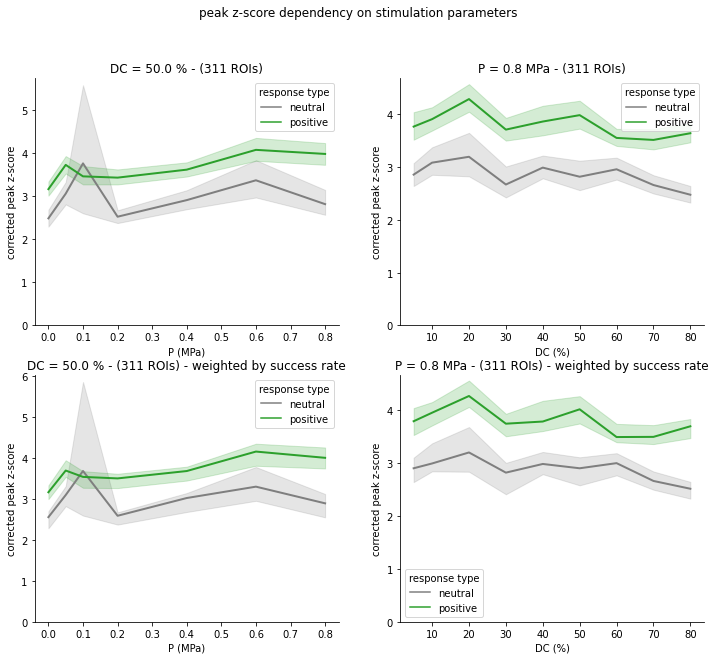

In [62]:
ykey = CORRECTED_PEAK_ZSCORE_LABEL
figs['peak_zscore_dependency'], axes = plt.subplots(2, 2, figsize=(12, 10))
for xkey, axrow in zip([P_LABEL, DC_LABEL], axes.T):
    for weightby, ax in zip([None, SUCCESS_RATE_LABEL], axrow):
        fig = plot_parameter_dependency(
            trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=ROI_RESP_TYPE_LABEL,
            weightby=weightby, ax=ax)
fig.suptitle('peak z-score dependency on stimulation parameters');

### Save figures

In [63]:
save_figs_book(figsdir, figs)

 17/11/2021 17:34:26: saving figure "dataset_info" on page 0
 17/11/2021 17:34:26: saving figure "raw_stack_run4" on page 1
 17/11/2021 17:34:26: saving figure "raw_stack_timecourse_run4" on page 2
 17/11/2021 17:34:26: saving figure "interp_stack_run4" on page 3
 17/11/2021 17:34:26: saving figure "interp_stack_timecourse_run4" on page 4
 17/11/2021 17:34:26: saving figure "filtered_stack_run4" on page 5
 17/11/2021 17:34:26: saving figure "filtered_stack_timecourse_run4" on page 6
 17/11/2021 17:34:27: saving figure "registered_images" on page 7
 17/11/2021 17:34:27: saving figure "registered_offsets" on page 8
 17/11/2021 17:34:27: saving figure "registered_stack_timecourse_run4" on page 9
 17/11/2021 17:34:27: saving figure "identified_ROIs" on page 10
 17/11/2021 17:34:27: saving figure "morpho_params_cells" on page 11
 17/11/2021 17:34:27: saving figure "raw_F_traces" on page 12
 17/11/2021 17:34:27: saving figure "F_trace" on page 13
 17/11/2021 17:34:28: saving figure "F_trace_

### Save stacks as GIFs

In [ ]:
# #raw and fileted stacks from specific run
# save_stack_to_gif(
#     figsdir, {'raw': raw_stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
#     ilabels=i_stim_frames_run)
# # registered stack (slice corresponding to specific run)
# save_stack_to_gif(
#     figsdir, s2p_ops, title='registered',
#     ilabels=istimframes_stacked, bounds=runbounds)

### Notify upon completion

In [ ]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 17/11/2021 16:45:37: notebook completed in 0:02:07.983018 s
